# A geocomputational notebook to monitor regional development in Bolivia

![](https://github.com/quarcs-lab/project2021o-notebook/blob/main/figs/cover.png?raw=true)

## Setup

In [ ]:
!pip install contextily -q
!pip install splot -q
!pip install inequality -q
!pip install mgwr -q

In [17]:
# Load libraries
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from pylab import rcParams
import matplotlib as mpl


import seaborn as sns
sns.set_style("darkgrid")

import plotly.express as px
import plotly.graph_objects as go

import geopandas as gpd

import contextily as cx

import libpysal
from libpysal  import weights
from libpysal.weights import Queen

import esda
from esda.moran import Moran, Moran_Local

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster, plot_local_autocorrelation
from splot.libpysal import plot_spatial_weights
from splot.mapping import vba_choropleth

import inequality
from inequality.gini import Gini_Spatial

import statsmodels.api as sm
import statsmodels.formula.api as smf

from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import shift_colormap, truncate_colormap

import warnings
warnings.filterwarnings('ignore')

In [18]:
dataURL = 'https://gist.github.com/cmg777/788a6c962f2d8f217ca44ff5dc567b5c/raw/ad1e0fd5b086eab7d90f5ba126c7839d4940f2e1/GeoDS4Bolivia.geojson'
gdf = gpd.read_file(dataURL)

## Select indicator

From the list below, let us select the development indicators that we want to study.

In [19]:
dataDefinitions = pd.read_csv('https://gist.githubusercontent.com/cmg777/979285c2bcde9832dd9cc0ee0fe9062d/raw/c4befc87572a744a7cd66b54ac233412a5f4ec2f/DataDefinitions.csv')
dataDefinitions

Variable                                   Label
0         poly_id                              Polygon ID
1         asdf_id                                 ASDF ID
2             mun                            Municipality
3          mun_id                         Municipality ID
4             dep                              Department
..            ...                                     ...
134  tr400_co2016  Trend estimated carbon dioxide in 2016
135  tr400_co2017  Trend estimated carbon dioxide in 2017
136  tr400_co2018  Trend estimated carbon dioxide in 2018
137  tr400_co2019  Trend estimated carbon dioxide in 2019
138  tr400_co2020  Trend estimated carbon dioxide in 2020

[139 rows x 2 columns]

In [20]:
variables = dataDefinitions['Variable']

In [21]:
INDICATOR1 = 'imds'
INDICATOR2 = 'pop2017'
INDICATOR3 = 'ln_t400NTLpc2017'
INDICATOR4 = 'co2017'

In [22]:
INDICATOR1 = 'imds'

In [23]:
INDICATOR2 = 'pop2017'

In [24]:
INDICATOR3 = 'ln_t400NTLpc2017'

In [25]:
INDICATOR4 = 'co2017'

## Descriptive statistics

- What do we know about the centrality and dispersion of our development indicator?

In [26]:
gdf[[INDICATOR1, INDICATOR2, INDICATOR3, INDICATOR4]].describe().round(2)

imds     pop2017  ln_t400NTLpc2017  co2017
count  339.00      339.00            339.00  339.00
mean    51.05    32858.76             13.67  403.59
std      6.77   117649.33              1.28    1.23
min     35.70      661.82              7.87  400.05
25%     47.00     6425.71             12.82  402.91
50%     50.50    11627.51             13.70  403.67
75%     54.85    22497.26             14.65  404.56
max     80.20  1604457.50             16.99  406.23

## Regional distribution

- How is our development indicator disbributed across the 339 municipalities and 9 departments of Bolivia?

In [27]:
px.strip(gdf, x = INDICATOR1, y = 'dep', color = 'dep', hover_name= 'mun', hover_data= ['rank_imds'],
        labels=dict(imds = 'Sustinable development index',
                    rank_imds = 'Development ranking',
                    mun = 'Municipality',
                    dep = 'Department')
        )

In [28]:
px.box(gdf, x = INDICATOR1, y = 'dep', color = 'dep', hover_name= 'mun', hover_data= ['rank_imds'],
        labels=dict(imds = 'Sustinable development index',
                    rank_imds = 'Development ranking',
                    mun = 'Municipality',
                    dep = 'Department')
        )

In [29]:
px.histogram(gdf, x = INDICATOR1, color = 'dep', hover_name= 'mun', marginal='rug', hover_data= ['rank_imds'],
            labels=dict(imds = 'Sustinable development index',
                        rank_imds = 'Development ranking',
                        mun = 'Municipality',
                        dep = 'Department')
            )

## The role of population

- Do the most populous regions tend to be more developed?

In [30]:
px.treemap(gdf, color = INDICATOR1, values = "pop2020", path = ["dep", "mun"], hover_name = "mun",
            hover_data= ['rank_imds'],
            labels=dict(imds = 'Development',
                        rank_imds = 'Development ranking',
                        pop2020 = 'Population in 2020',
                        mun = 'Municipality',
                        dep = 'Department')
            )

In [31]:
px.sunburst(gdf, color = INDICATOR1, values = "pop2020", path = ["dep", "mun"], hover_name = "mun",
            hover_data= ['rank_imds'],
            labels=dict(imds = 'Development',
                        rank_imds = 'Development ranking',
                        pop2020 = 'Population in 2020',
                        mun = 'Municipality',
                        dep = 'Department')
)

## Nighttime lights and development

- Can nighttime lights help us predict regional development?

In [32]:
px.scatter(gdf,
            x = INDICATOR3,
            y = INDICATOR1,
            color = 'dep',
            symbol = 'dep',
            hover_name= 'mun',
            trendline= 'ols',
            trendline_scope= 'overall',
            hover_data= ['rank_imds'],
            labels=dict(imds = 'Sustainable development index',
                        rank_imds = 'Development ranking',
                        ln_t400NTLpc2017 = 'Trend (log) nighttime lights per capita',
                        mun = 'Municipality',
                        dep = 'Department')

            )

How heterogeneious is the relatinship between regional development and nighttime lights?

In [33]:
px.scatter(gdf,
            x = INDICATOR3,
            y = INDICATOR1,
            color = 'dep',
            symbol = 'dep',
            hover_name= 'mun',
            trendline= 'ols',
            marginal_x="box",
            marginal_y="box",
            hover_data= ['rank_imds'],
            labels=dict(imds = 'Sustainable development index',
                        rank_imds = 'Development ranking',
                        ln_t400NTLpc2017 = 'Trend (log) nighttime lights per capita',
                        mun = 'Municipality',
                        dep = 'Department')
            )

## Geographic distribution

In [34]:
fig, ax = plt.subplots(figsize=(9,6))
gdf.plot(column= INDICATOR1,
            scheme='FisherJenks',
            k = 3,
            cmap='coolwarm',
            edgecolor='k',
            linewidth=0.5,
            alpha=0.8,
            legend=True,
            ax=ax,
            legend_kwds={'bbox_to_anchor':(1.00, 0.92)})
cx.add_basemap(ax, crs=gdf.crs.to_string(), source = cx.providers.Stamen.TonerHybrid, attribution=False)
plt.title('Spatial distribution of regional development: Three natural breaks')
plt.tight_layout()
ax.axis("off")
#plt.savefig('myMap.png',dpi=150, bbox_inches='tight')
plt.show()

In [35]:
gdf.explore(
    column= INDICATOR1,
    tooltip=['dep', 'mun', 'imds', 'rank_imds'],
    k = 3,
    scheme='FisherJenks',
    cmap='coolwarm',
    legend=True,
    tiles= 'Stamen Terrain',
    style_kwds =dict(color="gray", weight=0.4),
    legend_kwds=dict(colorbar=False)
)

## Spatial dependence

- To what extent is the performance of a region similar to that of its neighbours?
- To what extent is there is an overall pattern of "clustering"?
- Where can we find statistically significant spatial clusters?
- Where can we find statistically significant spatial outliers?

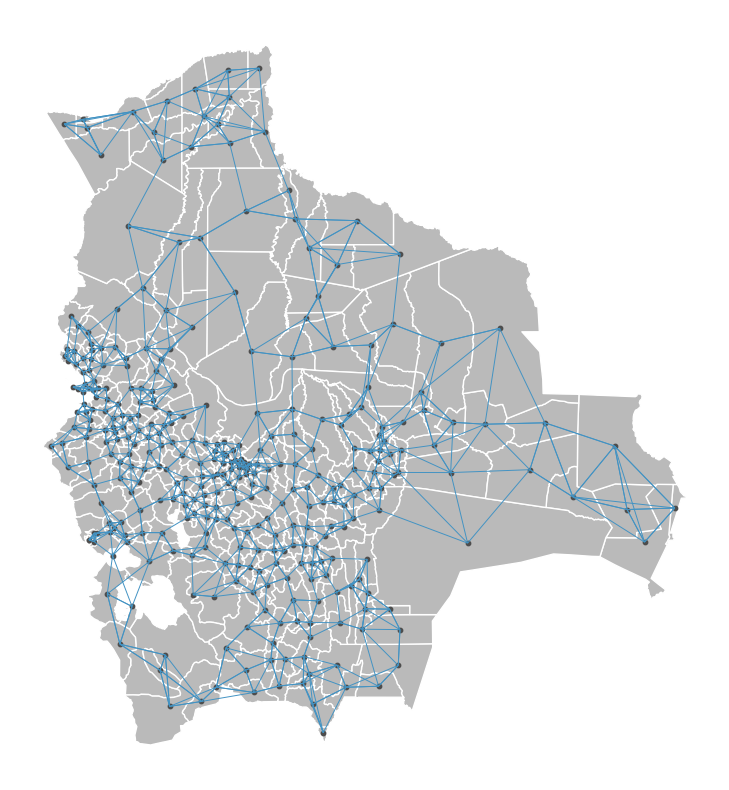

In [36]:
#W = weights.Queen.from_dataframe(gdf)
W = weights.KNN.from_dataframe(gdf, k=4)
W.transform = 'r'
plot_spatial_weights(W, gdf);

In [37]:
myLIST = ['asdf_id', 'mun', 'dep', 'dep_mun', INDICATOR1]
df_MORAN = gdf[myLIST]
df_MORAN["WxINDICATOR1"] = weights.lag_spatial(W, df_MORAN.iloc[: , -1])

In [38]:
px.scatter(
    df_MORAN,
    x= INDICATOR1,
    y= "WxINDICATOR1",
    hover_name= "mun",
    hover_data = ['dep', INDICATOR1, 'WxINDICATOR1'],
    trendline =  "ols",
    marginal_x = "box",
    marginal_y = "box",
    labels=dict(imds = 'Development index',
                WxINDICATOR1 = 'Development index in neighboring regions',
                rank_imds = 'Development ranking',
                mun = 'Municipality',
                dep = 'Department')
    )

In [39]:
globalMoran = Moran(gdf[INDICATOR1], W)
MoranI = globalMoran.I
MoranI = "{:.2f}".format(MoranI)
localMoran = Moran_Local(gdf[INDICATOR1], W, permutations = 999, seed=12345)

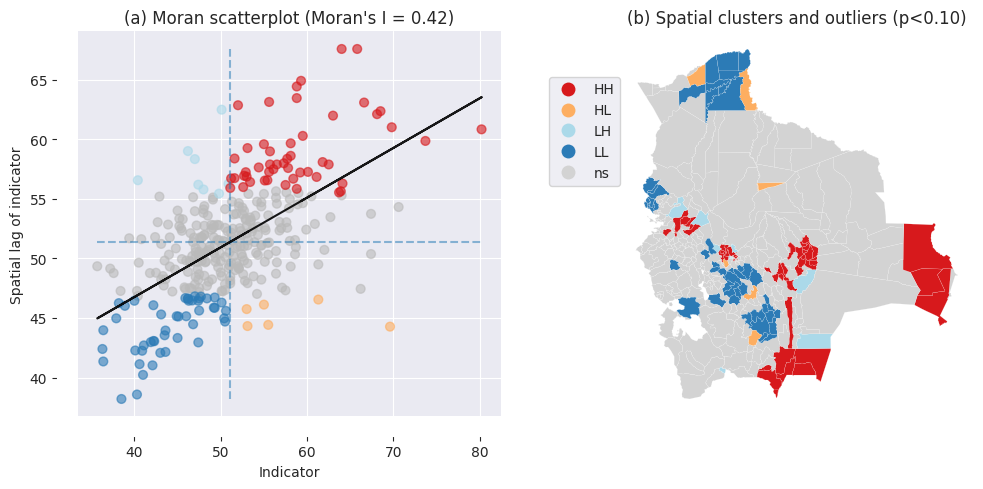

In [40]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
moran_scatterplot(localMoran, p=0.10, aspect_equal=False, zstandard = False, ax=axes[0])
lisa_cluster(localMoran, gdf, p=0.10, legend_kwds={'bbox_to_anchor':(0.02, 0.90)},  ax=axes[1])
#cx.add_basemap(axes[1], crs=gdf.crs.to_string(), source=cx.providers.Stamen.TonerLite, attribution=False)
#cx.add_basemap(axes[1], crs=gdf.crs.to_string(), source=cx.providers.Stamen.TonerLabels, attribution=False)
axes[0].set_xlabel('Indicator')
axes[0].set_ylabel('Spatial lag of indicator')
axes[0].set_title(f"(a) Moran scatterplot (Moran's I = {MoranI})")
axes[1].set_title("(b) Spatial clusters and outliers (p<0.10)")
plt.show()

## Spatial inequality

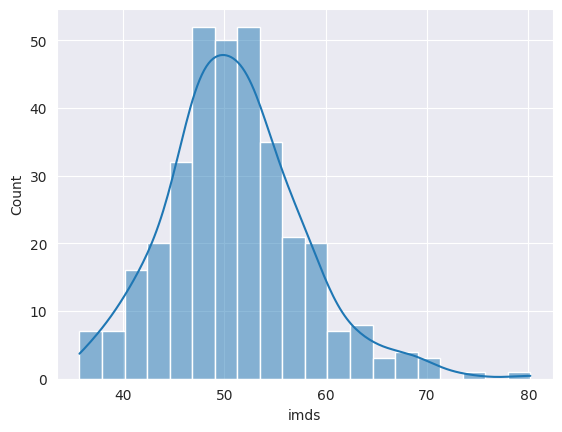

In [41]:
sns.histplot(x=gdf[INDICATOR1], kde=True);

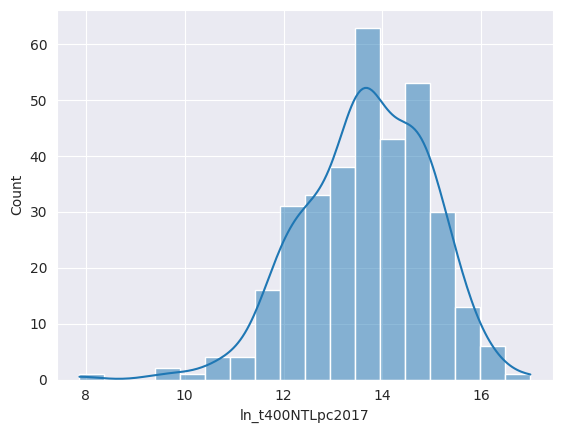

In [42]:
sns.histplot(x=gdf[INDICATOR3], kde=True);

Let's compute the standard gini index

In [43]:
inequality.gini.Gini(gdf[INDICATOR1].values).g

0.07282132196446878

In [44]:
inequality.gini.Gini(gdf[INDICATOR3].values).g

0.0521407680211148

Let's compute the spatial gini index

In [45]:
Gini_Spatial(gdf[INDICATOR1], W).wcg_share

0.07220311958338523

In [46]:
Gini_Spatial(gdf[INDICATOR1], W).p_sim

0.01

In [47]:
Gini_Spatial(gdf[INDICATOR3], W).wcg_share

0.051704979391114896

In [48]:
Gini_Spatial(gdf[INDICATOR3], W).p_sim

0.01

## Spatial heterogeneity

In [49]:
y = gdf[INDICATOR1].values.reshape((-1,1))
x = gdf[INDICATOR3].values.reshape((-1,1))

In [50]:
u = gdf['COORD_X']
v = gdf['COORD_Y']
coords = list(zip(u,v))

In [51]:
gwr_selector = Sel_BW(coords, y, x, spherical = True)
gwr_bw = gwr_selector.search(criterion='AICc')

In [52]:
print('GWR bandwidth =', gwr_bw)

GWR bandwidth = 46.0


In [53]:
gwr_results = GWR(coords, y, x, gwr_bw).fit()
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 339
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                          10221.458
Log-likelihood:                                                   -1058.379
AIC:                                                               2120.757
AICc:                                                              2122.829
BIC:                                                               8258.096
R2:                                                                   0.341
Adj. R2:                                                              0.339

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [54]:
# As reference, here is the (mean) R2, AIC, and AICc
print('Mean R2 =', gwr_results.R2)
print('AIC =',     gwr_results.aic)
print('AICc =',    gwr_results.aicc)

Mean R2 = 0.6040381097677936
AIC = 2021.188267111759
AICc = 2031.4418021891354


In [55]:
# Add R2 to GeoDataframe
gdf['gwr_R2'] = gwr_results.localR2

In [56]:
# Local R2
gdf.explore(
    column= 'gwr_R2',
    tooltip=['dep', 'mun', 'gwr_R2', 'rank_imds', INDICATOR1, INDICATOR3],
    k = 5,
    scheme='FisherJenks',
    cmap='coolwarm',
    legend=True,
    tiles= 'CartoDB dark_matter',
    style_kwds =dict(color="gray", weight=0.4),
    legend_kwds=dict(colorbar=False)
)

In [57]:
# Add coefficients to data frame
gdf['gwr_intercept'] = gwr_results.params[:,0]
gdf['gwr_slope']     = gwr_results.params[:,1]

In [58]:
# Filter t-values: standard alpha = 0.05
gwr_filtered_t = gwr_results.filter_tvals(alpha = 0.05)

In [59]:
# Filter t-values: corrected alpha due to multiple testing
gwr_filtered_tc = gwr_results.filter_tvals()

In [60]:
# Slope heterogeneity
gdf.explore(
    column= 'gwr_slope',
    tooltip=['dep', 'mun', 'gwr_slope', 'rank_imds', INDICATOR1, INDICATOR3],
    k = 5,
    scheme='FisherJenks',
    cmap='coolwarm',
    legend=True,
    tiles= 'CartoDB dark_matter',
    style_kwds =dict(color="gray", weight=0.4),
    legend_kwds=dict(colorbar=False)
)

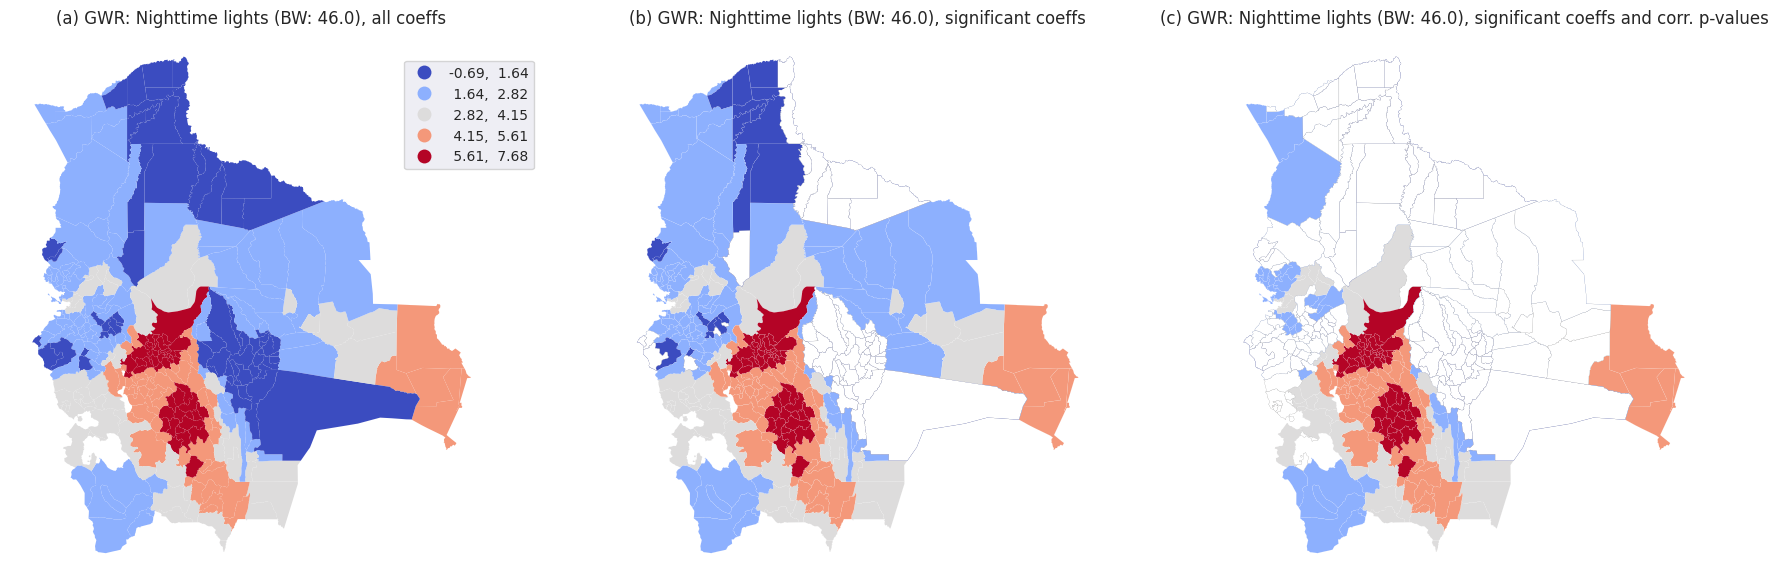

In [61]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,6))

gdf.plot(column='gwr_slope', cmap = 'coolwarm', linewidth=0.01, scheme = 'FisherJenks', k=5, legend=True, legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=axes[0])

gdf.plot(column='gwr_slope', cmap = 'coolwarm', linewidth=0.05, scheme = 'FisherJenks', k=5, legend=False, legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=axes[1])
gdf[gwr_filtered_t[:,1] == 0].plot(color='white', linewidth=0.05, edgecolor='black', ax=axes[1])


gdf.plot(column='gwr_slope', cmap = 'coolwarm', linewidth=0.05, scheme = 'FisherJenks', k=5, legend=False, legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=axes[2])
gdf[gwr_filtered_tc[:,1] == 0].plot(color='white', linewidth=0.05, edgecolor='black', ax=axes[2])

plt.tight_layout()

axes[0].axis("off")
axes[1].axis("off")
axes[2].axis("off")

axes[0].set_title('(a) GWR: Nighttime lights (BW: ' + str(gwr_bw) +'), all coeffs', fontsize=12)
axes[1].set_title('(b) GWR: Nighttime lights (BW: ' + str(gwr_bw) +'), significant coeffs',     fontsize=12)
axes[2].set_title('(c) GWR: Nighttime lights (BW: ' + str(gwr_bw) +'), significant coeffs and corr. p-values',     fontsize=12)
plt.show()